>**Etudiants : François MULLER et Pierre LAGUE**

# Sommaire
* [Etude Autoencodeur](#etude-ae)
    * [Exploration et création des bruits](#exploration-et-création-des-bruits)
    * [Création du jeu de données bruitées](#création-dun-dataset-bruité)
    * [Création dataloaders](#création-des-dataloaders-à-partir-des-datasets)
    * [Définition de l'Autoencodeur de débruitage (classes 1 et 7)](#definition-de-lautoencodeur-de-débruitage)
        * [Définition de l'optimisateur et loss](#definition-de-loptimisateur-de-la-loss-et-du-modèle)
        * [Méthode d'entraînement](#definition-de-la-methode-dentraînement-du-modèle)
        * [Premiers résultats du modèle](#résultats-de-lentraînement-du-modèle)
        * [Optimisation de l'architecture du modèle](#optimisation-de-larchitecture-du-modèle)
        * [Visualisation des prédictions](#visualisation-des-prédictions-du-modèle-sur-des-images-bruitées)

    * [Extension du modèle sur toutes les classes MNIST](#modèle-sur-lensemble-des-données-mnist)
    * [Implémentation d'architectures dérivées](#implémentation-de-nouvelles-architectures-dérivées)
        * [Définition du classifieur benchmark CNN](#définition-du-classifier-benchmark-cnn)
            * [Résultats Benchmark CNN](#résultat-benchmark-cnn)
        * [Définition du classifieur Encoder-MLP](#definition-du-classifier-encoder-mlp)
            * [Création du trainset avec les zones latentes](#création-du-jeu-dentraînement-avec-les-zones-latentes)
            * [Résultats du classifieur Encoder-MLP](#résultats-du-classifieur-encoder-mlp)
            * [GridSearch modèle Encodeur-MLP](#gridsearch-modèle-encodeur-mlp)
    * [Discussion sur les résultats obtenus](#discussion-sur-les-performances-de-modèles-encodeur-cnn-et-encodeur-mlp)





# Etude Autoencodeur <a class="anchor" id="etude-ae"></a>

Un autoencodeur est un réseau de neurones utilisé pour la réduction de dimension ; c'est-à-dire pour la sélection et l'extraction des caractéristiques. Les autoencodeurs avec plus de couches cachées que d'entrées courent le risque d'apprendre la fonction identité - où la sortie est simplement égale à l'entrée - devenant ainsi inutiles.
Les autoencodeurs de débruitage sont une extension de l'autoencodeur de base, et représentent une version stochastique de celui-ci. Les autoencodeurs de débruitage tentent de résoudre le risque de la fonction identité en corrompant aléatoirement l'entrée (c'est-à-dire en introduisant du bruit) que l'autoencodeur doit ensuite reconstruire, ou débruiter.

Une première partie de l'étude se concentre sur ces autoendcodeur de débruitage, l'optimisation de leur architecture et hyperparamètres ainsi que leur capacité à être robuste quand ils sont exposés à de nouvelles données.  Cette première partie se concentre égalmement sur l'importance de l'apprentissage de représentation et les caractéristiques de la zone latente.

In [1]:
import json
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from typing import Callable
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from keras.datasets import mnist
from torchvision import transforms
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import ParameterGrid

2024-04-10 22:35:15.217183: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 22:35:15.273322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 22:35:15.273371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 22:35:15.274775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 22:35:15.280757: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

### Exploration et création des bruits

>Justification des choix des données :

Dans le but de mieux appréhender le fonctionnement des autoencodeurs et d'illustrer leur capacité générative, nous avons pris la décision de construire un ensemble de données exclusivement composé d'images représentant les chiffres 1 et 7 (MNIST Digits). Les chiffres 1 et 7 présentent des similitudes marquées dans leur écriture. En introduisant divers types de bruits (dont nous discuterons ultérieurement), il devient possible de constituer un ensemble de données très varié et d'entraîner un modèle robuste. Par souci de performance et de faisabilité logistique, nous avons restreint notre choix à deux chiffres (1 et 7). Cependant, une exploration ultérieure sera proposée, où nous inclurons tous les chiffres du dataset MNIST.

>Justification des choix des bruits :

Deux types de bruits sont déjà implémentés, à savoir le "speckle" et le "gaussian".
- Le bruit speckle, également appelé bruit de chatoiement, fait référence à toute fluctuation parasite ou toute dégradation subie par une image depuis le moment de son acquisition jusqu'à son enregistrement. Ce bruit illustre un cas concret où l'image est capturée par un appareil numérique puis transmise au modèle, la présence de bruit étant inévitable. Ce type de bruit se distingue par sa capacité à séparer le premier plan de l'arrière-plan, ce qui met en valeur le chiffre tout en le dégradant.
- Le bruit gaussien, en traitement du signal, est un bruit caractérisé par une densité de probabilité qui suit une distribution gaussienne (loi normale). Les principales sources de bruit gaussien dans les images numériques surviennent pendant l'acquisition, par exemple le bruit du capteur causé par un mauvais éclairage et/ou une température élevée. Ce bruit uniforme permet au modèle d'être plus résilient dans sa classification car il n'accentue pas le chiffre mais uniformise la dégradation de l'image.
- Le bruit "salt and pepper", ou bruit sel ou poivre, correspond à une altération aléatoire subie par une image numérique, entraînant la modification de l'intensité de certains pixels (répartis de manière aléatoire dans l'image) jusqu'à atteindre la valeur minimale ou maximale de la plage dynamique du pixel, respectivement 0 et 255 dans le cas d'une image numérique codée en 8 bits. Ce type de bruit permet au modèle de traiter des valeurs extrêmes (0 ou 255).

Chacun des bruits sera scalé avec un paramètre `scale` qui permet de modifier l'intensité de la présence du bruit dans l'image. En jouant sur les valeurs de ce paramètre nous pourront créer des données plus ou moins bruitées et donc tester les limites de robustesse de nos modèles ainsi que de leur capacité à apprendre même avec beaucoup de bruit.



In [3]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
    'salt_and_pepper' Randomly chosen pixels that are converted in black or white based on a probability.
    'scale' : the scale at which the noise is present in the image. It allows to create images with little to no noise and images with a lot of noise (for model robustness).
                
We define a function that adds each noise when called from main function
Input & Output: np array
"""

def add_noise(img, noise_type="gaussian", scale=0.5):
  row, col = 28, 28
  img = img.astype(np.float32)

  match noise_type:
    case "gaussian":
      mean  = 0
      var   = 0.01
      sigma = var**.5
      noise = np.random.normal(mean, sigma, img.shape)
      noise = noise.reshape(row, col)
      img   = img + (noise*scale)
      return img
     
    case "speckle" :
      noise = np.random.randn(row, col)
      noise = noise.reshape(row, col)
      img   = img + (img*noise*scale)
      return img
     
    case "salt_pepper" :
      prob = 0.4*scale # 1/4 is the base probability of a pixel being transformed. It is scaled down or up with the scale parameter
      output = img.copy()
      if len(img.shape) == 2:
          black = 0
          white = 1
        
      probs = np.random.random(output.shape[:2])
      output[probs < (prob/2)] = black
      output[probs > 1-(prob/2)] = white
      return output     
    case _:
      return img


In [4]:
mnist_ = mnist.load_data()

# selection des chiffres 1 et 7 pour constituer nos jeux de données
train_mask = (mnist_[0][1] == 1) | (mnist_[0][1] == 7)
test_mask = (mnist_[1][1] == 1) | (mnist_[1][1] == 7)

(xtrain, ytrain) = mnist_[0][0][train_mask], mnist_[0][1][train_mask]
(xtest, ytest) = mnist_[1][0][test_mask], mnist_[1][1][test_mask]

In [5]:
xtrain = np.array([minmax_scale(x) for x in xtrain])
xtest = np.array([minmax_scale(x) for x in xtest])

In [6]:
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:13007
No of Test datapoints:2163


In [7]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((len(xtrain), 28, 28))


for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/3:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/3:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 24%|██▍       | 3111/13007 [00:00<00:00, 31104.39it/s]


gaussian noise addition completed to images


 78%|███████▊  | 10145/13007 [00:00<00:00, 15374.61it/s]


speckle noise addition completed to images


100%|██████████| 13007/13007 [00:01<00:00, 12024.46it/s]



salt_pepper noise addition completed to images


100%|██████████| 2163/2163 [00:00<00:00, 12682.08it/s]


gaussian noise addition completed to images

speckle noise addition completed to images

salt_pepper noise addition completed to images


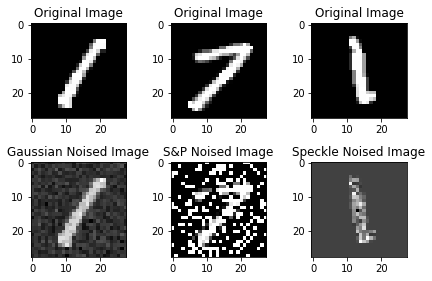

In [8]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,3)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Gaussian Noised Image")

#showing images with salt and pepper noise
axes[0,1].imshow(xtrain[13000], cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[13000], cmap="gray")
axes[1,1].set_title("S&P Noised Image")

#showing imags with the speckle noise
axes[0,2].imshow(xtrain[5000], cmap='gray')
axes[0,2].set_title("Original Image")
axes[1,2].imshow(traindata[5000], cmap="gray")
axes[1,2].set_title("Speckle Noised Image")

plt.tight_layout()

### Création d'un dataset bruité

La classe NoisedDataset, comme son nom l'indique est un dataset composé d'images bruitées. Le dataset est composé de tuples ayant la structure suivante :

$x = (image\_bruitée, image\_originale, label)$

Les types de bruits sont répartis uniformément dans le dataset de sorte à ce qu'il n'y ait pas de biais/déséquilibre.
Les fonctions de classe __len__ et __getitem__ vont nous permettre d'utiliser cette classe pour créer des dataloader rendant ainsi plus rapide le passage d'images en batch pendant l'entraînement.

In [9]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [10]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

#### Création des dataloaders à partir des datasets

In [11]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

### Definition de l'Autoencodeur de débruitage

Cet autoencodeur de débruitage est capable de prendre en entrée des images (ou des vecteurs) et de les encoder dans un espace de dimension réduite appelé "zone latente". Il les décode ensuite à partir de cet espace latent pour reconstruire l'entrée initiale sans le bruit.

Voici une explication des principaux éléments :

- La classe *denoising_model* est une sous-classe de nn.Module, ce qui signifie qu'elle hérite des fonctionnalités de base de PyTorch pour les modèles de réseaux de neurones.

- L'initialisateur __init__ de la classe permet de définir la structure de l'autoencodeur en spécifiant le nombre de couches cachées (hidden_layer_nb), le nombre de neurones dans chaque couche cachée (hidden_size), le nombre de neurones dans la zone latente (latent_size) et la taille de l'image en entrée (img_size).

- L'encodeur est une séquence de couches linéaires (fully connected) suivies de fonctions d'activation ReLU. Ces couches transforment l'entrée en une représentation de dimension réduite dans l'espace latent.

- Le décodeur est également une séquence de couches linéaires suivies de fonctions d'activation ReLU, mais cette fois-ci il restaure l'entrée originale à partir de la représentation de l'espace latent.

- La fonction forward est une méthode requise par PyTorch pour définir comment les données traversent le réseau. Dans ce cas, elle encode d'abord les données avec l'encodeur puis les décode avec le décodeur.

- La méthode get_latent_size retourne la taille de la zone latente.



In [12]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  """
  Autoencodeur, capable d'être personnalisé au niveau du nombre de neurones dans la / les couche(s) cachée(s) et au nombre de couches cachées.

  Paramètres :
  ------------
  `hidden_layer_nb`: int (default=1)  
    Nombre de couche cachées
  `hidden_size`: int (default=256)
    Nombre de neurones dans chaque couche de la couche cachée
  `latent_size`: int (default=64)  
    Nombre de neurone dans la zone latente
  """
  def __init__(self, hidden_layer_nb=1, hidden_size = 256, latent_size=64, img_size=28*28):
    super(denoising_model,self).__init__()

    self.latent_size = latent_size

    encode_sequence_input = [nn.Linear(img_size, hidden_size), nn.ReLU()]
    encode_sequence_output = [nn.Linear(hidden_size, latent_size), nn.ReLU()]
    encode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      encode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      encode_sequence_hidden.append(nn.ReLU())

    encode_sequence = encode_sequence_input + encode_sequence_hidden + encode_sequence_output
        
    self.encoder = nn.Sequential(
      *encode_sequence
    )

    decode_sequence_input = [nn.Linear(latent_size, hidden_size), nn.ReLU()]
    decode_sequence_output = [nn.Linear(hidden_size, img_size), nn.Sigmoid()]
    decode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      decode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      decode_sequence_hidden.append(nn.ReLU())

    decode_sequence = decode_sequence_input + decode_sequence_hidden + decode_sequence_output

    self.decoder = nn.Sequential(
      *decode_sequence
    )

  def get_latent_size(self):
    return self.latent_size

  def encode(self, x):
    return self.encoder(x)
 
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

#### Definition de l'optimisateur, de la loss et du modèle

Le choix d'une loss adaptées est très importante dans le process d'entraînement d'un modèle. La perte de Mean Squared Error (MSE) est appropriée pour les autoencodeurs en raison de sa compatibilité avec les espaces de sortie continus, de sa sensibilité aux erreurs importantes et de sa facilité de normalisation avec le calcul de la moyenne. Elle pénalise plus lourdement les erreurs importantes.

In [13]:
model = denoising_model(hidden_layer_nb=2).to(device) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [14]:
print(model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


### Definition de la methode d'entraînement du modèle

La méthode train_test permet de réaliser l'entraînement et l'évaluation d'un modèle (`model`) passé en paramètre.

Cette méthode permet de spécifier l'optimisateur utilisé ainsi que la loss, le nombre d'epochs, le device (pour la gpu acceleration), le trainloader et le testloader.
Il nous semblait important de pouvoir spécifier tous ces paramètres afin de rendre la méthode la plus réutillisable possible.

Pendant la phase d'entraînement, nous calculons la perte moyenne de l'epoch afin de garder une trace de la performance du modèle.


Cette fonction permet d'entraînet le modèle mais aussi de l'évaluer. En effet, après la phase d'entraînement sur le trainloader, nous calculons la loss totale (MSE) sur le testloader.
Ce calcul est fait manuellement : 

- nous comparons la valeur du label à la valeur prédite par le modèle. En fonction de la nature du testloader, il est important de modifier le type des données de test afin qu'elles soient compatibles en entrée avec le modèle (d'où les transtypages en tenseurs).
- la true_error est incrémentée de 1 si le label et la prédiction correspondent, 0 sinon

Au final nous retournons l'ensemble des loss au fil des epochs et la true_error.



In [15]:
def train_test(
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        criterion: torch.nn.Module, 
        epochs: int,
        device: str,
        trainloader: torch.utils.data.DataLoader, 
        testset: torch.utils.data.Dataset):
    """
    Fonction pour entraîner / tester un modèle.

    Parameters:
    -----------
    model : torch.nn.Module
        Le modèle à entraîner.
    optimizer : torch.optim.Optimizer
        L'optimiseur utilisé pour la mise à jour des poids du modèle.
    criterion : torch.nn.Module
        La fonction de perte utilisée pour évaluer la différence entre les prédictions et les vraies étiquettes.
    epochs : int
        Le nombre d'époques d'entraînement.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        Le DataLoader contenant les données d'entraînement.
    testset : torch.utils.data.Dataset
        Le jeu de données de test utilisé pour évaluer le modèle après chaque époque.

    Returns:
    --------
    true_error : float
        L'erreur moyenne quadratique sur le jeu de données de test.
    losslist : list
        Liste des valeurs de la fonction de perte moyenne sur les données d'entraînement pour chaque époque.
    """
    model.train()
    losslist = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for dirty, clean, label in trainloader:  
            
            dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
            clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
            dirty, clean = dirty.to(device), clean.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model.forward(dirty)
            loss = criterion(output, clean)

            # Rétropropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Calcul de la perte moyenne pour cette époque
        losslist.append(running_loss/len(trainloader))

    # Calcul de l'erreur moyenne quadratique sur le jeu de données de test
    true_error = 0
    for test in testset:
        true_error += mean_squared_error(test.flatten(), model(torch.tensor(test.flatten()).type(torch.FloatTensor)).detach())
    true_error /= len(testset)

    return true_error, losslist

Nous entraînons un modèle type autoencodeur de béruitage qui nous servira de baseline pour comparer les autres modèles.

In [16]:
train_test(model, optimizer, criterion, 120, device, trainloader, testdata)

100%|██████████| 120/120 [16:04<00:00,  8.04s/it]


(0.015559103894430694,
 [0.034819886134136516,
  0.024979666241556772,
  0.023845272157020887,
  0.022975859799735817,
  0.022100311044960554,
  0.021234249812836874,
  0.020614106876258476,
  0.02008196713828484,
  0.0196032400519864,
  0.019169708418703343,
  0.018955685333314487,
  0.01868421603817978,
  0.01862100592107313,
  0.018523550901278232,
  0.018433818026132313,
  0.018349159508943558,
  0.018279949949106946,
  0.018271389939073995,
  0.018167106112057952,
  0.018147058233490592,
  0.01811539842598415,
  0.01797543959669238,
  0.017992873772228232,
  0.017803503767900738,
  0.017739181361030743,
  0.017833380550329164,
  0.01766419951879495,
  0.01756411146244414,
  0.017592352922520708,
  0.01753280642247903,
  0.01749974768837635,
  0.017424805426205846,
  0.01738349280574105,
  0.017455092171339788,
  0.017348828560761944,
  0.017385777404087914,
  0.017372134475710205,
  0.01730158140411468,
  0.017226266338322905,
  0.017296255298453116,
  0.01728715069582846,
  0.017

#### Résultats de l'entraînement du modèle

Au terme de l'entraînement qui à duré 16 minutes environ, on observe une loss qui décroit de 2% à 1%, ce qui montre une performance relativement bonne du modèle pendant son entraînement. Ce score est en accord avec son erreur de generalisation d'environ 1% montrant sa capacité à débruiter des données non présentes lors de l'entraînement. A présent, tentons d'optimiser le modèle afin de gagner en performance.

### Optimisation de l'architecture du modèle


In [17]:
def gridsearch(model_obj: nn.Module, 
               parameters: dict,
               optimizer: optim.Optimizer,
               criterion,
               learning_rate :int,
               epoch: int,
               device: str,
               trainloader: DataLoader,
               testdata: Dataset):
    """
    Effectue une recherche sur grille pour trouver les meilleurs hyperparamètres pour un modèle donné.

    Parameters:
    -----------
    model_obj : nn.Module
        Classe du modèle à utiliser pour la recherche sur grille.
    parameters : dict
        Dictionnaire contenant les hyperparamètres à tester.
    optimizer : torch.optim.Optimizer
        L'optimiseur à utiliser pour la mise à jour des poids du modèle.
    learning_rate : int
        Taux d'apprentissage à utiliser avec l'optimiseur.
    epoch : int
        Nombre d'époques d'entraînement pour chaque configuration de paramètres.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        DataLoader contenant les données d'entraînement.
    testdata : torch.utils.data.Dataset
        Jeu de données de test utilisé pour évaluer le modèle après chaque configuration de paramètres.

    Returns:
    --------
    results : dict
        Dictionnaire contenant les résultats de la recherche sur grille.
        Chaque clé correspond à l'indice de la configuration de paramètres.
        Chaque valeur est un dictionnaire contenant les paramètres testés, l'erreur réelle (sur les données de test)
        et l'erreur d'entraînement (sur les données d'entraînement) pour cette configuration.
    """
    parameters = ParameterGrid(parameters)
    results = {}
    loss = criterion()

    for i, params in enumerate(parameters):
        tmp_model = model_obj(**params)
        tmp_optim = optimizer(tmp_model.parameters(), lr=learning_rate)
        tmp_result = train_test(tmp_model, tmp_optim, loss, epoch, device, trainloader, testdata)
        print(f"\tParams {i}/{len(parameters)} -> true error: {tmp_result[0]}")
        results[i] = {
            "params": params,
            "true_error": tmp_result[0],
            "training_error": tmp_result[1]
        }

    return results

In [18]:
parameters = {"hidden_layer_nb": range(1, 6, 2),
              "hidden_size": range(300, 501, 100),
              "latent_size": [7*7, 8*8, 9*9]}

In [19]:
results = gridsearch(denoising_model, parameters, optim.Adam, nn.MSELoss, 1e-4, 30, device, trainloader, testdata)

100%|██████████| 30/30 [01:15<00:00,  2.53s/it]


	Params 0/27 -> true error: 0.011610495447013659


100%|██████████| 30/30 [01:19<00:00,  2.64s/it]


	Params 1/27 -> true error: 0.011604238712075948


100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


	Params 2/27 -> true error: 0.012100017227890576


100%|██████████| 30/30 [01:42<00:00,  3.42s/it]


	Params 3/27 -> true error: 0.011341067950738663


100%|██████████| 30/30 [01:34<00:00,  3.13s/it]


	Params 4/27 -> true error: 0.012203814334264748


100%|██████████| 30/30 [01:42<00:00,  3.41s/it]


	Params 5/27 -> true error: 0.011429345076944101


100%|██████████| 30/30 [02:09<00:00,  4.30s/it]


	Params 6/27 -> true error: 0.01102463743060008


100%|██████████| 30/30 [02:12<00:00,  4.42s/it]


	Params 7/27 -> true error: 0.01093688843767824


100%|██████████| 30/30 [02:10<00:00,  4.35s/it]


	Params 8/27 -> true error: 0.01133331167077896


100%|██████████| 30/30 [02:03<00:00,  4.12s/it]


	Params 9/27 -> true error: 0.023175082362316725


100%|██████████| 30/30 [01:59<00:00,  3.97s/it]


	Params 10/27 -> true error: 0.02336531763943763


100%|██████████| 30/30 [01:53<00:00,  3.78s/it]


	Params 11/27 -> true error: 0.02528539040027918


100%|██████████| 30/30 [02:21<00:00,  4.72s/it]


	Params 12/27 -> true error: 0.018921343922841297


100%|██████████| 30/30 [02:31<00:00,  5.04s/it]


	Params 13/27 -> true error: 0.023120474372961115


100%|██████████| 30/30 [02:35<00:00,  5.20s/it]


	Params 14/27 -> true error: 0.022402909466689595


100%|██████████| 30/30 [03:00<00:00,  6.02s/it]


	Params 15/27 -> true error: 0.023136744308596358


100%|██████████| 30/30 [03:35<00:00,  7.19s/it]


	Params 16/27 -> true error: 0.017518676950472205


100%|██████████| 30/30 [03:25<00:00,  6.86s/it]


	Params 17/27 -> true error: 0.02221039675797116


100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


	Params 18/27 -> true error: 0.03291889349792379


100%|██████████| 30/30 [02:46<00:00,  5.54s/it]


	Params 19/27 -> true error: 0.029836618698641355


100%|██████████| 30/30 [02:43<00:00,  5.45s/it]


	Params 20/27 -> true error: 0.032885634758703694


100%|██████████| 30/30 [03:36<00:00,  7.21s/it]


	Params 21/27 -> true error: 0.03572675071837763


100%|██████████| 30/30 [03:55<00:00,  7.84s/it]


	Params 22/27 -> true error: 0.02453191977050692


100%|██████████| 30/30 [04:03<00:00,  8.11s/it]


	Params 23/27 -> true error: 0.034908066636488745


100%|██████████| 30/30 [05:35<00:00, 11.18s/it]


	Params 24/27 -> true error: 0.02574615945052277


100%|██████████| 30/30 [05:58<00:00, 11.97s/it]


	Params 25/27 -> true error: 0.02335401143256641


100%|██████████| 30/30 [05:45<00:00, 11.52s/it]


	Params 26/27 -> true error: 0.02607099017858946


In [20]:
# # on enregistre les résultats pour ne pas devoir refaire la gridsearch
# with open("output_gridsearch.json", "w+") as file:
#     file.write(json.dumps(results, indent=1))

# on lit les résultats de l'ancienne gridsearch
with open("output_gridsearch.json") as file:
    results = json.loads(file.read())

In [21]:
[results[str(i)]["params"] for i in range(27) if results[str(i)]["true_error"] == min([results[str(j)]["true_error"] for j in range(27)])][0]

{'hidden_layer_nb': 1, 'hidden_size': 500, 'latent_size': 81}

Afin de trouver le meilleur modèle pour cette tâche, nous avons réalisé un grid search sur plusieurs paramètres :
- Le nombre de couches de la couche cachée (par le paramètres `hidden_layer_nb`)
- Le nombre de neurones de la couche cachées (par le paramètres `hidden_size`)
- Le nombre de neurones de la zone latente (par le paramètres `latent_size`)  

Nous avons opté pour des espaces latents sous forme de carrés afin de pouvoir les afficher ultérieurement dans le même format que les images d'origine, qui sont également carrées. Cette approche sera également avantageuse pour la classification, car elle permettra l'utilisation de réseaux de convolution tout en préservant les dimensions de base des images.

En raison de contraintes de temps, nous avons limité à seulement 30 itérations par test lors de la recherche par grille. Le programme a pris plus d'une heure pour s'exécuter avec seulement ces 30 itérations. Nous avons utilisé le même optimiseur et le même taux d'apprentissage que lors de notre premier test.

Le meilleur modèle possède donc cette forme :
```
denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=81, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
```
C'est à dire, par rapport aux paramètres donnés :
- Le paramètre `hidden_layer_nb` vaut 1
- Le paramètre `hidden_size` vaut 500
- Le paramètre `latent_size` vaut 81 (donc $9 \times 9$)

In [22]:
best_model = denoising_model(**[results[str(i)]["params"] for i in range(27) if results[str(i)]["true_error"] == min([results[str(j)]["true_error"] for j in range(27)])][0])
best_model_optim = optim.Adam(best_model.parameters(), lr=1e-3)
best_model_criterion = nn.MSELoss()
print(best_model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=81, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [23]:
true_error, losslist = train_test(best_model, best_model_optim, best_model_criterion, 100, device, trainloader, testdata)
# best_model.load_state_dict(torch.load("model", map_location=device))

100%|██████████| 100/100 [08:13<00:00,  4.94s/it]


([<matplotlib.lines.Line2D at 0x734bdfca6b00>], 0.05422814199700569)

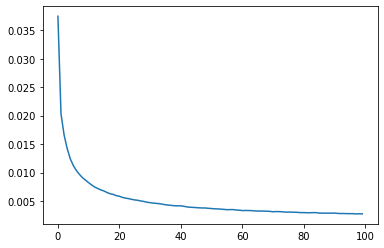

In [24]:
plt.plot(range(len(losslist)), losslist), true_error

### Visualisation des prédictions du modèle sur des images bruitées

On teste le modèle avec des données bruitées. L'intensité du bruit est similaire à celle présente lors de l'entraînement.

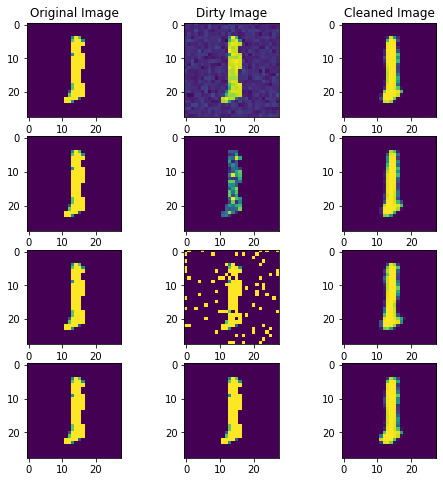

In [25]:
f,axes= plt.subplots(4,3,figsize=(8, 8))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[3]), noise)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[3])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

L'affichage de ces images montre que notre modèle `best_model` est capable de reconstituer l'image originale malgrès la présence de bruit. On remarque même que l'image reconstituée à des contours plus précis que l'image originale.

Après avois établi cette baseline, nous pouvons nous intéresser à la robustesse de notre modèles. Ceci peut se faire en augmentant le bruit (paramètre `scale`). Le modèle va maintenant avoir des images beaucoup plus bruitées que celles sur lesquelles il s'est entraîné.

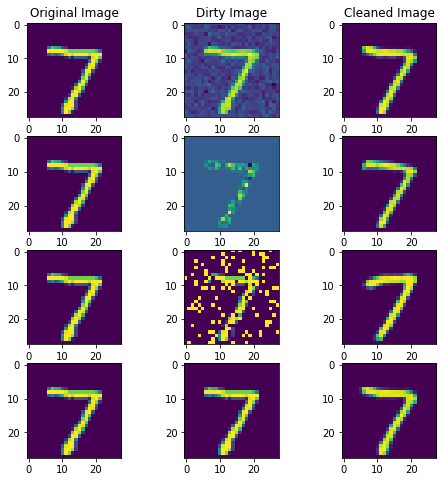

In [26]:
f,axes= plt.subplots(4,3,figsize=(8, 8))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[0]), noise, 0.8)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[0])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

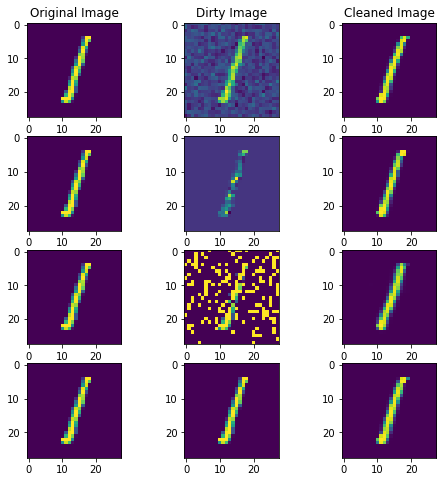

In [27]:
f,axes= plt.subplots(4,3,figsize=(8, 8))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    dirty = add_noise(np.array(xtest[1]), noise, 1)
    predicted = best_model(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(xtest[1])
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(predicted.detach().numpy().reshape((28, 28)))

Pour le 1 comme pour le 7, ces images montrent que notre modèle est capable de reconstituer des images même si le degré de bruit est élevé. 
Il est généralisable à des données qui n'ont pas le même degré de bruit dans les images utilisées pour entraîner notre modèle.

In [28]:
# PATH = "model"
# torch.save(best_model.state_dict(), PATH)  # We save the model state dict at PATH   

### Modèle sur l'ensemble des données MNIST

A présent, nous allons déployer un modèle sur l'ensemble des données MNIST afin de tester la capacité qu'à notre modèle à classifier plusieurs classes.

In [29]:
(xtrain_all, ytrain_all) = mnist_[0][0], mnist_[0][1]
(xtest_all, ytest_all) = mnist_[1][0], mnist_[1][1]

xtrain_all = np.array([minmax_scale(x) for x in xtrain_all])
xtest_all = np.array([minmax_scale(x) for x in xtest_all])

In [30]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata_all = np.zeros((len(xtrain_all), 28, 28))


for idx in tqdm(range(len(xtrain_all))):
  if noise_ct < len(xtrain_all)/3:
    noise_ct += 1
    traindata_all[idx] = add_noise(xtrain_all[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata_all = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest_all))):
  if noise_ct < len(xtest)/3:
    x = add_noise(xtest_all[idx], noise_type=noises[noise_id])
    testdata_all[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 45%|████▌     | 27189/60000 [00:00<00:00, 35864.75it/s]


gaussian noise addition completed to images


 79%|███████▉  | 47623/60000 [00:01<00:00, 42422.04it/s]


speckle noise addition completed to images


100%|██████████| 60000/60000 [00:01<00:00, 38322.87it/s]



salt_pepper noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 40644.92it/s]


gaussian noise addition completed to images


In [31]:
trainset_all = noisedDataset(traindata_all, xtrain_all, ytrain_all, tsfms)
testset_all= noisedDataset(testdata_all, xtest_all, ytest_all, tsfms)

In [32]:
trainloader_all = DataLoader(trainset_all, batch_size=500, shuffle=True)
testloader_all  = DataLoader(testset_all, batch_size=1, shuffle=True)

Nous reprenons la même architecture que nous avons trouvé précédemment afin d'observer sa capacité de généralisation.

In [33]:
best_model_all = denoising_model(**[results[str(j)]["params"] for j in range(27) if results[str(j)]["true_error"] == min([results[str(i)]["true_error"] for i in range(27)])][0])
best_model_criterion_all = nn.MSELoss()
best_model_optim_all = optim.Adam(best_model_all.parameters(), lr=4e-3)
best_model_all

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=81, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=81, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [34]:
testset_all = np.array([testset_all[i][0].numpy() for i in range(len(testset_all))])

In [35]:
true_error_all, losslist_all = train_test(best_model_all, best_model_optim_all, best_model_criterion_all, 100, device, trainloader_all, testset_all)
# best_model_all = denoising_model(**[results[str(j)]["params"] for j in range(27) if results[str(j)]["true_error"] == min([results[str(i)]["true_error"] for i in range(27)])][0])
# best_model_all.load_state_dict(torch.load("model_all", map_location=device))
# best_model_all.eval()

100%|██████████| 100/100 [08:15<00:00,  4.95s/it]


In [36]:
true_error_all

0.014089820474208327

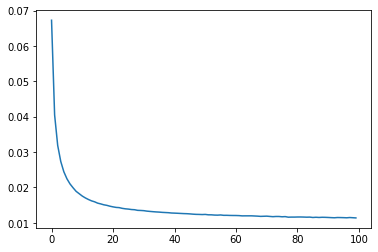

In [37]:
plt.plot(losslist_all)

On observe que la loss de notre modèle décroit au fil des epochs en se rapprochant de 0. 
Après 100 epochs, on peut voir qu'on peut potentiellement atteindre une loss plus basse en augmentant le nombre d'épochs. Cependant, c'est un modèle très lourd (toutes les classes sont comprises) et l'entraînement peut prendre plusieurs 10aines de minutes.

In [38]:
torch.save(best_model_all.state_dict(), "model_all")  # We save the model state dict at PATH   

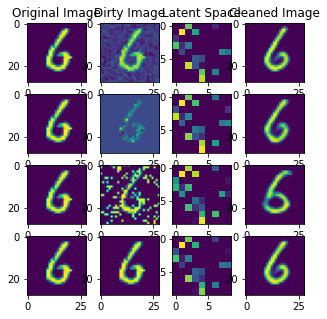

In [39]:
f,axes= plt.subplots(4,4,figsize=(5,5))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Latent Space")
axes[0,3].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    clean = xtest_all[50]
    dirty = add_noise(np.array(clean), noise, 0.8)
    predicted = best_model_all(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(clean)
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(best_model_all.encode(torch.tensor(dirty.flatten()).type(torch.FloatTensor)).detach().numpy().reshape((9, 9)))
    axes[i, 3].imshow(predicted.detach().numpy().reshape((28, 28)))

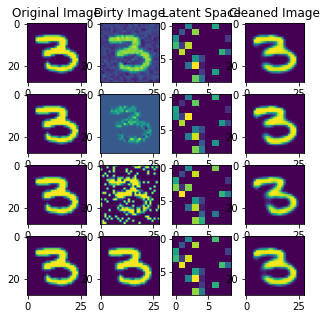

In [40]:
f,axes= plt.subplots(4,4,figsize=(5,5))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Latent Space")
axes[0,3].set_title("Cleaned Image")
for i, noise in enumerate(["gaussian", "speckle", "salt_pepper", ""]):
    clean = xtest_all[51]
    dirty = add_noise(np.array(clean), noise, 0.8)
    predicted = best_model_all(torch.tensor(dirty.flatten()).type(torch.FloatTensor))

    axes[i, 0].imshow(clean)
    axes[i, 1].imshow(dirty.reshape((28, 28)))
    axes[i, 2].imshow(best_model_all.encode(torch.tensor(dirty.flatten()).type(torch.FloatTensor)).detach().numpy().reshape((9, 9)))
    axes[i, 3].imshow(predicted.detach().numpy().reshape((28, 28)))

Nous observons que le modèle possédant toutes les classes est capable de reconstituer les images malgré un bruit important. 
Le précédent modèle n'ayant pas eu d'images autre que 1 et 7 n'était pas capable de reconstituer des images d'autres chiffres. Ici, on observe bien le principe d'apprentissage de représentation via la zone latente, où multiples classes sont apprises par l'encodeur et ainsi reconstituées par le décodeur.

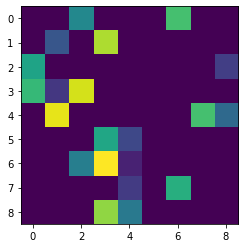

In [41]:
plt.imshow(best_model_all.encode(torch.tensor(dirty.flatten()).type(torch.FloatTensor)).detach().numpy().reshape((9, 9)))

Il est possible d'extraire la zone latente entre l'encodeur et le decodeur. Cette zone latente est la version la plus réduite de l'image (9x9 pixels contre 28x28 à l'origine). C'est ce type de données qui va permettre au modèle de réaliser l'apprentissage de représentation. Ce type de données sera utilisé plus tard dans l'étude pour faire un Encodeur-MLP : 

- un classifieur ayant comme architecture encodeur -> zone latente -> input pour MLP -> multi-classification.

---


# Implémentation de nouvelles architectures dérivées

In [42]:
best_model_all.load_state_dict(torch.load("model_all", map_location=device))

<All keys matched successfully>

De manière équivalente à `train_test`, la fonction `train_classifier` permet d'entraîner un modèle en spécifiant un grand nombre de paramètres. Cependant, la partie test se fait en dehors pour des raisons de simplicité.

La fonction commence par mettre le modèle en mode d'entraînement (`model.train()`). Ensuite, elle itère sur le nombre spécifié d'époques, effectuant une passe avant et une passe arrière (rétropropagation) à chaque itération sur les données d'entraînement.

Pour chaque lot de données dans `trainloader`, la fonction effectue les étapes suivantes :
1. Remise à zéro des gradients (`optimizer.zero_grad()`).
2. Passage avant pour obtenir les sorties prédites par le modèle.
3. Calcul de la perte entre les sorties prédites et les vraies étiquettes à l'aide de la fonction de perte spécifiée (`criterion`).
4. Rétropropagation de la perte pour calculer les gradients des paramètres du modèle (`loss.backward()`).
5. Mise à jour des poids du modèle en utilisant l'optimiseur (`optimizer.step()`).
6. Calcul de la perte cumulée pour cette époque.

À la fin de chaque époque, la perte moyenne sur les données d'entraînement est calculée en divisant la somme des pertes cumulées par le nombre total de lots (`len(trainloader)`), puis ajoutée à la liste `losslist`.

Enfin, la fonction retourne la liste `losslist`, contenant les valeurs de la fonction de perte moyenne sur les données d'entraînement pour chaque époque.

In [43]:
def train_classifier(
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        criterion: torch.nn.Module, 
        epochs: int,
        device: str,
        trainloader: torch.utils.data.DataLoader):
    """
    Fonction pour entraîner / tester un modèle.

    Parameters:
    -----------
    model : torch.nn.Module
        Le modèle à entraîner.
    optimizer : torch.optim.Optimizer
        L'optimiseur utilisé pour la mise à jour des poids du modèle.
    criterion : torch.nn.Module
        La fonction de perte utilisée pour évaluer la différence entre les prédictions et les vraies étiquettes.
    epochs : int
        Le nombre d'époques d'entraînement.
    device : str
        L'appareil sur lequel exécuter l'entraînement, par exemple 'cuda' pour GPU ou 'cpu' pour CPU.
    trainloader : torch.utils.data.DataLoader
        Le DataLoader contenant les données d'entraînement.

    Returns:
    --------
    losslist : list
        Liste des valeurs de la fonction de perte moyenne sur les données d'entraînement pour chaque époque.
    """
    model.train()
    losslist = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for output, label in trainloader:  
            optimizer.zero_grad()

            # Forward pass
            output = model(output)
            label = label.clone().detach()
            loss = criterion(output, label)

            # Rétropropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Calcul de la perte moyenne pour cette époque
        losslist.append(running_loss/len(trainloader))

    # Calcul de l'erreur moyenne quadratique sur le jeu de données de test

    return losslist

### Définition du classifier Benchmark CNN

**L'objectif est de comparer ce classifier benchmark a une architecture Encoder-MLP**.

Ce modèle CNN (Convolutional Neural Network) comprend deux couches de convolution suivies chacune d'une fonction d'activation ReLU et d'une opération de max pooling. De plus, il y a une couche entièrement connectée à la fin. Ce modèle est conçu pour traiter des images en niveaux de gris de taille 28x28 pixels.

In [44]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=2, stride=1)
        self.fc = nn.Linear(1 * 6 * 6, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 1 * 6 * 6)
        x = self.fc(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

Plus tôt dans l'étude, nous avons décrit notre fonction `train_classifier` mais selon la méthodologie, il est important de pouvoir tester notre modèle sur des données incoonues pour évaluer sa généralisation.

La `true_error_func`, est conçue pour calculer le taux d'erreur sur un ensemble de données de test pour un modèle donné, ainsi nous donnant un indicateur de la qualité de sa généralisation.

- **Description** :
  1. L'assertion `assert len(xtest) == len(ytest), "Pas la meme taille entre le x et y"` vérifie que les données de test `xtest` et les étiquettes `ytest` ont la même longueur. Si elles ne sont pas de la même taille, un message d'erreur est affiché.
  2. La variable `true_error` est initialisée à 0 pour stocker le nombre d'erreurs de classification.
  3. La fonction parcourt les données de test et leurs étiquettes correspondantes à l'aide d'une boucle `for i in range(len(xtest))`.
  4. Pour chaque exemple de test, la fonction compare la prédiction du modèle avec l'étiquette réelle :
     - Si la prédiction du modèle n'est pas égale à l'index de l'étiquette réelle (obtenu en utilisant `torch.argmax`), cela signifie qu'une erreur de classification s'est produite. Dans ce cas, 1 est ajouté à la variable `true_error`.
     - Sinon, aucune erreur n'est ajoutée à `true_error`.
  5. Après avoir parcouru toutes les données de test, la fonction divise le nombre total d'erreurs (`true_error`) par le nombre total d'exemples de test pour obtenir le taux d'erreur moyen.
  6. Le taux d'erreur moyen est renvoyé comme sortie de la fonction.

In [45]:
def true_error_func(model: torch.nn.Module, 
                    xtest: torch.Tensor, 
                    ytest: torch.Tensor) -> float:
    """
    Calcule le taux d'erreur sur un ensemble de données de test pour un modèle donné.

    Parameters:
    -----------
    model : torch.nn.Module
        Le modèle de réseau de neurones à évaluer.
    xtest : torch.Tensor
        Les données de test en entrée.
    ytest : torch.Tensor
        Les étiquettes correspondantes des données de test.

    Returns:
    --------
    float
        Le taux d'erreur moyen sur l'ensemble de données de test.
    """
    assert len(xtest) == len(ytest), "Pas la meme taille entre le x et y"
    true_error = 0
    for i in range(len(xtest)):
        true_error += 1 if ytest[i] != torch.argmax(model(xtest[i])) else 0
    true_error /= len(xtest)
    return true_error


In [46]:
cnn_benchmark = CNN()
bench_optim = optim.Adam(cnn_benchmark.parameters(), 1e-4)
bench_crite = nn.CrossEntropyLoss()
batch_size=128
bench_data = []

for img in tqdm(traindata_all):
    bench_data.append(torch.tensor(img).type(torch.float32))
bench_training_data = DataLoader(list(zip(bench_data, ytrain_all)), batch_size=batch_size, shuffle=False)

100%|██████████| 60000/60000 [00:00<00:00, 79623.46it/s]


In [47]:
losslist_classif_benchmark = train_classifier(cnn_benchmark, bench_optim, bench_crite, 150, device, bench_training_data)

100%|██████████| 150/150 [06:53<00:00,  2.76s/it]


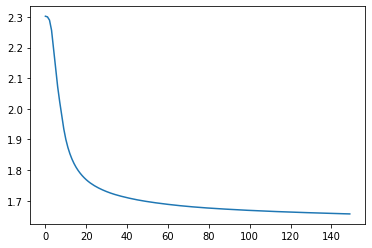

In [48]:
plt.plot(losslist_classif_benchmark)

In [49]:
precision = 0
for i in range(len(xtest_all)):
    precision += 1 if ytest_all[i] == torch.argmax(cnn_benchmark(torch.tensor(xtest_all[i]).type(torch.float32))) else 0
precision /= len(xtest_all)
precision

0.8706

#### Résultat Benchmark CNN

Les résultats précédents nous montrent que notre modèle CNN n'est pas de très grande qualité. Pendant son entraînement, la loss n'atteint pas de valeur en dessous de 1, ce qui laisse à désirer la qualité de la classification. Puis, en calculant sont accuracy sur le jeu de test, on trouve 87% et 12% d'erreur. Ce modèle créé une bonne baseline sur laquelle comparer le modèle suivant.

### Definition du classifier (Encoder-MLP)

**Ce modèle entre en compétition avec notre claassifier CNN**


Ce classifieur va prendre en entrée la zone latente (sortie de l'encodeur) et va nous servir de baseline en termes d'architecture Encodeur-Classifier.

Il s'agit d'un classificateur de type MLP :  `small_classifier`.

- **Initialisation** : La méthode `__init__` initialise les paramètres du réseau. Elle prend en argument `hidden_size` (la taille des couches cachées), `hidden_nb` (le nombre de couches cachées), `input_size` (la taille de l'entrée) et `output_size` (la taille de la sortie). À l'intérieur de la méthode `__init__` :
  - Une liste appelée `sequence_input` est créée, contenant une couche linéaire (`nn.Linear`) suivie d'une fonction d'activation ReLU (`nn.ReLU()`). Cela représente la couche d'entrée.
  - Une autre liste appelée `sequence_output` est créée, contenant une couche linéaire suivie d'une fonction d'activation softmax (`nn.Softmax(dim=1)`), représentant la couche de sortie.
  - Une liste vide appelée `sequence_hidden` est créée pour contenir les couches cachées.
  - Une boucle itère `hidden_nb` fois, ajoutant des paires de couches linéaires suivies de fonctions d'activation ReLU à `sequence_hidden`.
  - Toutes ces séquences de couches sont combinées dans une liste appelée `classif_sequence`, représentant la séquence de couches dans le classificateur.

- **Modèle séquentiel** : Les couches définies dans `classif_sequence` sont ensuite passées à `nn.Sequential()`, qui crée un modèle de réseau de neurones composé de ces couches en séquence. Ce modèle séquentiel est stocké dans l'attribut `self.classifier`.

- **Propagation avant** : La méthode `forward` définit comment les données d'entrée `x` circulent à travers le réseau lors de la propagation avant. Elle passe simplement l'entrée `x` à travers le modèle séquentiel (`self.classifier`) et renvoie la sortie.

En résumé, cette classe définit un classificateur de réseau de neurones simple avec un nombre personnalisable de couches cachées, chacune avec une taille spécifiée et une fonction d'activation ReLU. Les couches d'entrée et de sortie sont également personnalisables, la couche de sortie utilisant une activation softmax pour les tâches de classification multiclasses.

In [50]:
class Encoder_MLP_classifier(nn.Module):
    def __init__(self, hidden_size, hidden_nb, input_size=81, output_size=10) -> None:
        super().__init__()

        sequence_input = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        sequence_output = [nn.Linear(hidden_size, output_size), nn.Softmax(dim=1)]
        sequence_hidden = []
        for i in range(hidden_nb):
            sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
            sequence_hidden.append(nn.ReLU())

        classif_sequence = sequence_input + sequence_hidden + sequence_output
            
        self.classifier = nn.Sequential(
            *classif_sequence
        )
    
    def forward(self, x):
        return self.classifier(x)

### Création du jeu d'entraînement avec les zones latentes

La case suivante initialise le jeu `training_data` constitué de toutes les zones latentes après le passage des images du jeu `traindata_all` dans l'encodeur que nous avons implémenté plus haut. Cette manière d'initialiser le jeu de données nous évite beaucoup de difficultés sur la résolution des dimensions si cette opération était faite dans la boucle d'entraînement. De cette manière, nous avons un dataloader qui peut être parcouru par notre modèle `small_classifier`de type MLP.

In [68]:
encoder_output = []
for img in tqdm(traindata_all):
    encoder_output.append(best_model_all.encode(torch.tensor(img.flatten()).type(torch.float32)).clone().detach())
training_data = DataLoader(list(zip(encoder_output, ytrain_all)), batch_size=batch_size, shuffle=False)

100%|██████████| 60000/60000 [00:07<00:00, 7617.43it/s]


In [69]:
# # on enregistre les résultats pour ne pas devoir refaire la gridsearch
# with open("output_gridsearch_classif.json", "w+") as file:
#     file.write(json.dumps(results, indent=1))

# on lit les résultats de l'ancienne gridsearch
with open("output_gridsearch_classif.json") as file:
    results = json.loads(file.read())

In [70]:
classifier_encoder_mlp = Encoder_MLP_classifier(**[results[str(j)]["params"] for j in range(21) if results[str(j)]["true_error"] == min([results[str(i)]["true_error"] for i in range(21)])][0])
classif_optim = optim.Adam(classifier_encoder_mlp.parameters(), 5e-5)
classif_crite = nn.CrossEntropyLoss()
batch_size=16
print(classifier_encoder_mlp)

Encoder_MLP_classifier(
  (classifier): Sequential(
    (0): Linear(in_features=81, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): ReLU()
    (12): Linear(in_features=20, out_features=10, bias=True)
    (13): Softmax(dim=1)
  )
)


In [71]:
losslist_classif = train_classifier(classifier_encoder_mlp, classif_optim, classif_crite, 120, device, training_data)

100%|██████████| 120/120 [11:39<00:00,  5.83s/it]


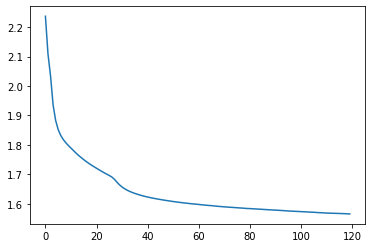

In [72]:
plt.plot(losslist_classif)

In [73]:
encode_xtest_all = []
for img in tqdm(xtest_all):
    encode_xtest_all.append(best_model_all.encode(torch.tensor(img.flatten()).type(torch.float32)).view(-1, 9, 9).clone().detach())

100%|██████████| 10000/10000 [00:01<00:00, 5737.65it/s]


In [74]:
true_error_func(classifier_encoder_mlp, [encode_xtest_all[i].view(1, -1).type(torch.float32) for i in range(len(encode_xtest_all))], ytest_all)

0.0872

### Résultats du classifieur Encoder-MLP

Le calcul de l'erreur réelle avec la fonction `true_error_func` nous retourne une erreure réelle de 8% et accuracy 92%, ce qui est un meilleur score que le modèle CNN. Toutefois, la loss au cours de l'entraînement ne descends pas en dessous de 1, ce qui remet en jeu la qualité de la classification. L'erreur réellé indique que notre modèle est capable de se généraliser a des données inconnues. Mais nous ne pouvons pas assurer sa fiabilité avec la loss de son entraînement. De manière générale, le modèle Encodeur-MLP est meilleur que le modèle CNN.

--- 


### Gridsearch modèle Encodeur-MLP


Voici la gridsearch utilisée pour optimiser les paramètres du modèle Encoder_MLP_classifier.

In [61]:
encoder_output = []
for img in tqdm(traindata_all):
    encoder_output.append(best_model_all.encode(torch.tensor(img.flatten()).type(torch.float32)).clone().detach())
training_data = DataLoader(list(zip(encoder_output, torch.tensor(ytrain_all.reshape((-1, 1))).type(torch.float32))), batch_size=batch_size, shuffle=False)

100%|██████████| 60000/60000 [00:09<00:00, 6043.92it/s]


In [62]:
def gridsearch_classif(model_obj: nn.Module, 
               parameters: dict,
               optimizer: optim.Optimizer,
               criterion,
               learning_rate :int,
               epoch: int,
               device: str,
               trainloader: DataLoader,
               xtestdata: Dataset,
               ytestdata):
    parameters = ParameterGrid(parameters)
    results = {}
    loss = criterion()

    for i, params in enumerate(parameters):
        tmp_model = model_obj(**params)
        tmp_optim = optimizer(tmp_model.parameters(), lr=learning_rate)
        tmp_result = train_classifier(tmp_model, tmp_optim, loss, epoch, device, trainloader)
        error_result = true_error_func(tmp_model, xtestdata, ytestdata)
        print(f"\tParams N°{i+1}/{len(parameters)} -> true error: {error_result} / {params=}")
        results[i] = {
            "params": params,
            "true_error": error_result,
            "training_error": tmp_result
        }

    return results

parameters = {
    "hidden_nb": range(1, 6, 2),
    "hidden_size": range(20, 81, 10),
}

results = gridsearch_classif(Encoder_MLP_classifier, parameters, optim.Adam, nn.MSELoss, 1e-4, 25, device, training_data, [encode_xtest_all[i].view(1, -1).type(torch.float32) for i in range(len(encode_xtest_all))], ytest_all)

  0%|          | 0/25 [00:00<?, ?it/s]/home/franzele/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]


	Params N°1/21 -> true error: 0.9014 / params={'hidden_nb': 1, 'hidden_size': 20}


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


	Params N°2/21 -> true error: 0.8855 / params={'hidden_nb': 1, 'hidden_size': 30}


100%|██████████| 25/25 [01:19<00:00,  3.18s/it]


	Params N°3/21 -> true error: 0.8917 / params={'hidden_nb': 1, 'hidden_size': 40}


100%|██████████| 25/25 [01:21<00:00,  3.27s/it]


	Params N°4/21 -> true error: 0.8929 / params={'hidden_nb': 1, 'hidden_size': 50}


100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


	Params N°5/21 -> true error: 0.8945 / params={'hidden_nb': 1, 'hidden_size': 60}


100%|██████████| 25/25 [01:30<00:00,  3.62s/it]


	Params N°6/21 -> true error: 0.8866 / params={'hidden_nb': 1, 'hidden_size': 70}


100%|██████████| 25/25 [01:40<00:00,  4.02s/it]


	Params N°7/21 -> true error: 0.9278 / params={'hidden_nb': 1, 'hidden_size': 80}


100%|██████████| 25/25 [01:27<00:00,  3.51s/it]


	Params N°8/21 -> true error: 0.8865 / params={'hidden_nb': 3, 'hidden_size': 20}


100%|██████████| 25/25 [01:53<00:00,  4.52s/it]


	Params N°9/21 -> true error: 0.9149 / params={'hidden_nb': 3, 'hidden_size': 30}


100%|██████████| 25/25 [01:57<00:00,  4.69s/it]


	Params N°10/21 -> true error: 0.8972 / params={'hidden_nb': 3, 'hidden_size': 40}


100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


	Params N°11/21 -> true error: 0.8628 / params={'hidden_nb': 3, 'hidden_size': 50}


100%|██████████| 25/25 [02:07<00:00,  5.09s/it]


	Params N°12/21 -> true error: 0.968 / params={'hidden_nb': 3, 'hidden_size': 60}


100%|██████████| 25/25 [02:10<00:00,  5.22s/it]


	Params N°13/21 -> true error: 0.9042 / params={'hidden_nb': 3, 'hidden_size': 70}


100%|██████████| 25/25 [02:27<00:00,  5.90s/it]


	Params N°14/21 -> true error: 0.8712 / params={'hidden_nb': 3, 'hidden_size': 80}


100%|██████████| 25/25 [02:09<00:00,  5.18s/it]


	Params N°15/21 -> true error: 0.8586 / params={'hidden_nb': 5, 'hidden_size': 20}


100%|██████████| 25/25 [02:27<00:00,  5.89s/it]


	Params N°16/21 -> true error: 0.8779 / params={'hidden_nb': 5, 'hidden_size': 30}


100%|██████████| 25/25 [02:31<00:00,  6.04s/it]


	Params N°17/21 -> true error: 0.8916 / params={'hidden_nb': 5, 'hidden_size': 40}


100%|██████████| 25/25 [02:38<00:00,  6.33s/it]


	Params N°18/21 -> true error: 0.9053 / params={'hidden_nb': 5, 'hidden_size': 50}


100%|██████████| 25/25 [02:45<00:00,  6.62s/it]


	Params N°19/21 -> true error: 0.9054 / params={'hidden_nb': 5, 'hidden_size': 60}


100%|██████████| 25/25 [02:54<00:00,  6.99s/it]


	Params N°20/21 -> true error: 0.8887 / params={'hidden_nb': 5, 'hidden_size': 70}


100%|██████████| 25/25 [03:02<00:00,  7.29s/it]


	Params N°21/21 -> true error: 0.9167 / params={'hidden_nb': 5, 'hidden_size': 80}


In [66]:
[results[j]["params"] for j in range(21) if results[j]["true_error"] == min([results[i]["true_error"] for i in range(21)])][0]

{'hidden_nb': 5, 'hidden_size': 20}

In [67]:
with open("output_gridsearch_classif.json", "w+") as file:
    file.write(json.dumps(results, indent=1))

## Discussion sur les performances de modèles Encodeur-CNN et Encodeur-MLP

Après avoir testé notre Autoencodeur de débruitage, nous avons développé des architectures dérivées qui utilisent l'apprentissage de représentation de notre encodeur (nottament la zone latente) afin d'évaluer comment cette zone latente pouvait être utilisée à des fins de classification multiclasse.

La première architecture que nous avons considéré est la suivante :

```
 ____________________________________________________________________________________________
|                   Classification CNN model (simplified version)                            |
|____________________________________________________________________________________________|                 
|                                                                                            |
|                   CNN (Input: image_noisy)                                                 |
|   Input (latent zone) --> Conv2D Hidden Layers (MaxPooling2D) ... --> Output (Softmax)     |
|                                                                                            |
|____________________________________________________________________________________________|
```

Le but est que le CNN puisse établir une baseline en terme de classification multiclasse. De même que pour l'autoencoder, le CNN utilise des informations très basse dimensions similaires à la zone latente. Il représente alors un bon concurrent pour le modèle Encodeur-MLP.
Les résultats montrent que cette architecture atteint 87% d'accuracy avec 12% d'erreur. Ces performances différents des standards de la littérature sur les données MNIST, mais il faut prendre en compte que les données sont bruitées, avec 3 variation de bruit différentes. Ceci enlève les informations contextuelle de l'image qui ne permet pas au CNN d'extraire des informations nécessaire à la reconnaissance du chiffre. En observant des images issues du jeu d'entraînement, on voit bien que l'image manque de patterns et d'informations. En effet, les CNN sont conçus pour apprendre des représentations hiérarchiques des caractéristiques spatiales, en commençant par des bords et des textures simples jusqu'à des formes complexes et des parties d'objets. Si les données ne présentent pas cette structure hiérarchique, les couches supplémentaires dans les CNN pourraient ne pas apporter d'avantages significatifs. Une architecture trop complexe comme les CNN serait alors inneficace pour ce genre de classification sur des images dont les informations contextuelles sont bruitées.


La seconde architecture que nous avons considéré est la suivante :

```
 ____________________________________________________________________________________________
|                   Classification Encoder-MLP model (simplified version)                    |
|____________________________________________________________________________________________|
|                                                                                            |
|                   Encoder (Input: img_size)                                                |
|   Input --> Hidden Layers (ReLU) ... --> Output (latent zone)                              |
|                                                                                            |
|                   MLP (Input: latent_size)                                                 |
|   Input (latent zone) --> Linear Layers (ReLU) ... --> Output (Softmax)                    |
|                                                                                            |
|____________________________________________________________________________________________|
```

Le but est que le MLP puisse utiliser la zone latente pour extraire des informations de cette dernière et effectuer une classification. Contrairement à l'étude précédente, les résultats sont très bons (8% d'erreur, 92% d'accuracy). Les MLP sont des réseaux entièrement connectés et peuvent apprendre des relations non linéaires complexes entre les caractéristiques d'entrée. Ils ne sont pas contraints par les relations spatiales dans les données, contrairement aux CNN qui supposent des corrélations spatiales locales dans l'entrée. Dans un espace de petite dimension comme la zone latente, les caractéristiques pertinentes pour la classification ne sont pas facilement discernables au niveau des pixels mais émergent plutôt d'une combinaison de valeurs de pixels, les MLP, grace à leur couches cachées peuvent avoir une meilleure compréhension de l'information, sans avoir a chercher des informations contextuelles. Dans ce cas, l'architecture simpliste des MLP correspond à la nature très simple des données de la zone latente.


**Nous pouvons conclure l'étude en affirmant que le modèle Encodeur-MLP est plus performant que le modèle standard CNN pour classifier des données bruitées.**




In [75]:
torch.save(classifier_encoder_mlp.state_dict(), "classifieur")  # We save the model state dict at PATH
torch.save(cnn_benchmark.state_dict(), "benchmark")   